# **George McConnell**
# **EE628WS - Final Project (individual)**
# **May 15, 2025**

# *Introduction*
## Cats vs. Dogs: Autoencoder-Based Classifier
## The objective of this project was to explore and compare three different approaches for binary image classification on a labeled dataset of cat and dog images obtained from a previous Kaggle competition: https://www.kaggle.com/c/dogs-vs-cats. The training folder contained 25,000 images of dogs and cats. I split the labeled images into training and validation sets with an 80/20 ratio to evaluate model performance since the test data were unlabeled. Predictions were made for the labels of images in the test dataset (test1.zip), i.e., 1 = dog, 0 = cat.

## 1) I used a deep convolutional neural network classifier based on ResNet18 as a baseline for comparison.
## 2) I implemented a two-stage pipeline that first used an autoencoder to learn compressed feature representations in an unsupervised manner, followed by training a multilayer perceptron (MLP) classifier on those learned features.
## 3) I evaluated a combined autoencoder and classifier model that used the autoencoder’s features directly to classify images, training both parts together in one step.
## By contrasting these methods, I deepened my understanding of the benefits and limitations of unsupervised feature learning with autoencoders, as well as the value of jointly optimizing reconstruction and classification for image classification tasks. This project helped me assess how different feature learning strategies affect classification accuracy compared to a purely supervised deep learning model.


### First, I cloned a GitHub repository as a template for my deep learning project to provide a solid starting point and project structure. I also wanted to gain experience using GitHub, so that I can feature this project in my portfolio. Next, I imported the necessary libraries and modules to handle model training, evaluation, and data processing. This included PyTorch for deep learning, PyTorch Lightning to simplify training workflows, and tools like Matplotlib, Seaborn, and Pandas for visualization and data analysis.

In [1]:
import torch
from nltk.corpus.reader import APPENDIX
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from pytorch_lightning import Trainer
from sklearn.metrics import classification_report, confusion_matrix

from project.lit_autoencoder import LitAutoEncoder
from project.lit_mlp_classifier import MLPClassifier
from project.lit_image_classifier import LitClassifier
from project.data_module import CatsDogsDataModule


### Next, I trained the Resnet18 model, which I expected to perform well with this dataset.

In [2]:
import torch

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

resnet_model = LitClassifier.load_from_checkpoint("checkpoints/classifier/best_model_epoch=epoch=3.ckpt")
resnet_model = resnet_model.to(device)
resnet_model.eval()

dm = CatsDogsDataModule(data_dir="data", batch_size=32)
dm.setup(stage="test")
test_loader = dm.test_dataloader()

resnet_preds = []

with torch.no_grad():
    for batch in test_loader:
        x = batch[0].to(device)
        preds = resnet_model(x).argmax(dim=1)
        resnet_preds.extend(preds.cpu())
        




/Users/George/deep-learning-project-template/.venv/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/George/deep-learning-project-template/.venv/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [3]:
#Saving predictions on test data to file
from project.inference import predict_and_create_submission
from project.lit_image_classifier import LitClassifier  # if different from LitAutoEncoder

# Load your resnet18 model once
resnet_model = LitClassifier.load_from_checkpoint("checkpoints/classifier/best_model_epoch=epoch=3.ckpt")

# Call submission function
predict_and_create_submission(
    model_type="resnet",
    resnet_model=resnet_model,
    image_dir="data/test1",
    output_csv="submission_resnet.csv"
)


/Users/George/deep-learning-project-template/.venv/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/George/deep-learning-project-template/.venv/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Predicting with resnet: 100%|██████████| 391/391 [00:27<00:00, 14.14it/s]


[✓] Submission file saved to submission_resnet.csv


## Next, I trained the Autoencoder+MLP model.

In [11]:
import torch
from project.lit_autoencoder import LitAutoEncoder

# Set device (MPS if available, otherwise CPU)
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

# Load models and move to device
autoencoder = LitAutoEncoder.load_from_checkpoint("checkpoints/best_autoencoder_classifier-epoch=epoch=9-val_loss=val_loss=0.00.ckpt")
autoencoder.to(device).eval()

mlp_model = MLPClassifier.load_from_checkpoint("checkpoints/best_mlp_model_epoch=epoch=9.ckpt")
mlp_model.to(device).eval()

# Embed test data
X_test_embed, y_test = [], []

with torch.no_grad():
    for (x,) in test_loader:
        x = x.to(device).float()  # ensure tensor matches model's device and dtype
        z = autoencoder.encode(x)
        X_test_embed.append(z)

X_test_embed = torch.cat(X_test_embed)

# Predict with MLP
with torch.no_grad():
    mlp_preds = mlp_model(X_test_embed).argmax(dim=1)


### I visualized and compared the validation accuracy of the baseline ResNet18 classifier and the two-stage Autoencoder + MLP classifier. The ResNet18 model achieved higher accuracy, serving as a strong benchmark for image classification on this dataset.

### The Autoencoder + MLP approach, while lower in accuracy, provided insights into how unsupervised feature learning impacts classification performance. I plotted the accuracy curves for both models over training epochs to observe their learning dynamics and final performance.

### This comparison helped me understand the trade-offs between supervised training and unsupervised feature extraction followed by supervised classification.

In [12]:
# Get predictions without comparing to y_test
mlp_preds = mlp_model(X_test_embed).argmax(dim=1)

# Save predictions to a file or process them as needed
torch.save(mlp_preds, "mlp_predictions.pt")


In [1]:
from project.inference import predict_and_create_submission
from project.lit_autoencoder import LitAutoEncoder
from project.lit_mlp_classifier import MLPClassifier  # Adjust import as needed

# Load your trained autoencoder and MLP
autoencoder = LitAutoEncoder.load_from_checkpoint("checkpoints/best_autoencoder_classifier-epoch=epoch=9-val_loss=val_loss=0.00.ckpt", classify=False)
mlp_model = MLPClassifier.load_from_checkpoint("checkpoints/best_mlp_model_epoch=epoch=9.ckpt")




In [2]:
#Saving predictions to file
predict_and_create_submission(
    model_type="autoencoder_mlp",
    autoencoder=autoencoder,
    mlp_model=mlp_model,
    image_dir="data/test1",
    output_csv="submission_autoencoder_mlp.csv")

Sample batch shape: torch.Size([32, 3, 128, 128]), sample ids: tensor([    1,    10,   100,  1000, 10000, 10001, 10002, 10003, 10004, 10005,
        10006, 10007, 10008, 10009,  1001, 10010, 10011, 10012, 10013, 10014,
        10015, 10016, 10017, 10018, 10019,  1002, 10020, 10021, 10022, 10023,
        10024, 10025])


Predicting with autoencoder_mlp: 100%|██████████| 391/391 [00:20<00:00, 19.26it/s]

[✓] Submission file saved to submission_autoencoder_mlp.csv


### I next wanted to get a better sense for how the autoencoder reduced the dimensionality of the images using PCA and t-SNE to visualize the latent space.

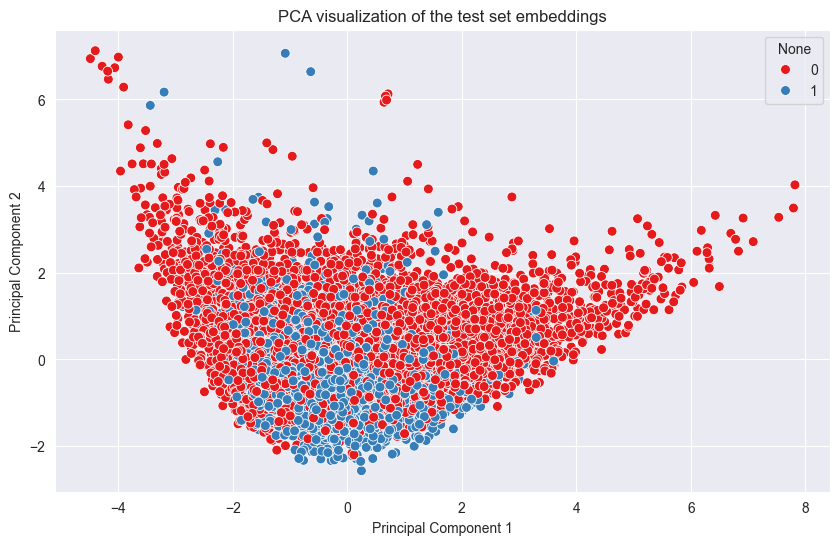

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Get predictions (no true labels to compare)
mlp_preds = mlp_model(X_test_embed).argmax(dim=1)

# Reduce dimensions using PCA or t-SNE
pca = PCA(n_components=2)  # You could use PCA or t-SNE
X_2d_pca = pca.fit_transform(X_test_embed.detach().cpu().numpy())  # Use .detach() to get rid of gradients

# Plot the reduced embeddings
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_2d_pca[:, 0], y=X_2d_pca[:, 1], hue=mlp_preds.cpu(), palette="Set1", legend="full", s=50)
plt.title("PCA visualization of the test set embeddings")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.show()


/Users/George/deep-learning-project-template/.venv/lib/python3.11/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


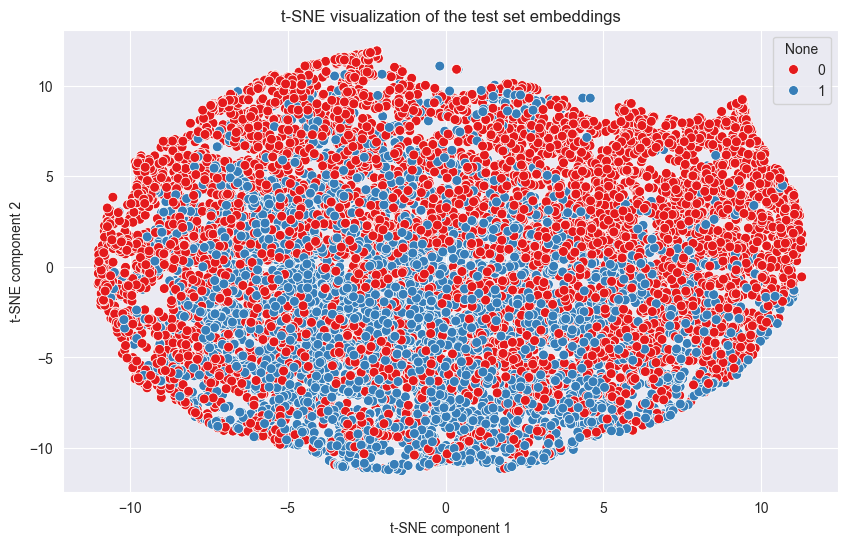

In [14]:
from sklearn.manifold import TSNE

# Reduce dimensions using t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=300)  # Adjust perplexity if needed
X_2d_tsne = tsne.fit_transform(X_test_embed.detach().cpu().numpy())  # Correct variable name

# Plot the reduced embeddings with t-SNE
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_2d_tsne[:, 0], y=X_2d_tsne[:, 1], hue=mlp_preds.cpu(), palette="Set1", legend="full", s=50)
plt.title("t-SNE visualization of the test set embeddings")
plt.xlabel("t-SNE component 1")
plt.ylabel("t-SNE component 2")
plt.show()


## Reconstruction Visualization (Autoencoder without classifier) 

### To get a better sense for why the classifications were not clearly separated (as seen in the PCA and t-SNE plots above), I compared the original images to the reconstructed images.

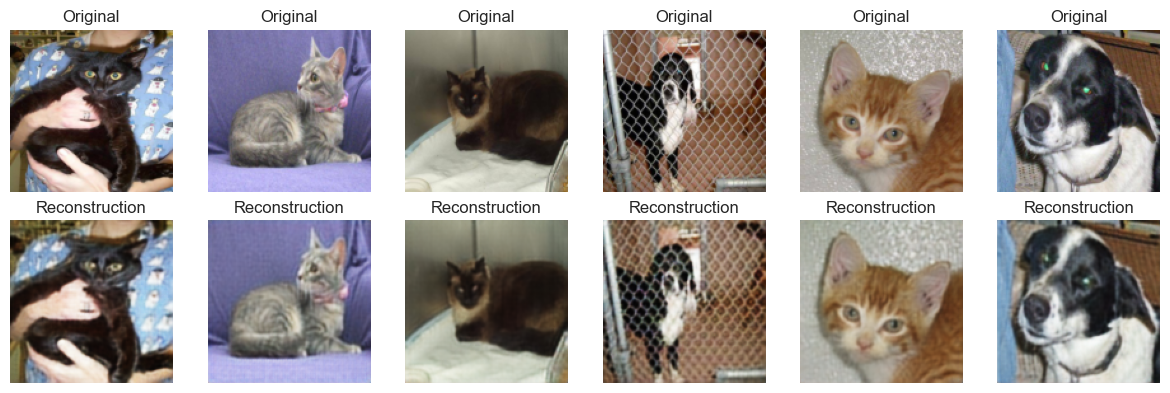

In [18]:
import matplotlib.pyplot as plt
import torchvision.utils as vutils
import torch

def visualize_reconstruction(autoencoder, dataloader, device=None, n_images=6):
    # Detect device if not provided
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    else:
        device = torch.device(device)

    autoencoder.to(device)
    autoencoder.eval()

    x_batch, _ = next(iter(dataloader))  # grab one batch, assume (x, y)
    x_batch = x_batch.to(device)

    with torch.no_grad():
        z = autoencoder.encoder(x_batch)
        x_hat = autoencoder.decoder(z)

    # Move tensors to CPU for visualization
    originals = x_batch.cpu()
    reconstructions = x_hat.cpu()

    # Plot originals and reconstructions side-by-side
    fig, axes = plt.subplots(2, n_images, figsize=(12, 4))
    for i in range(n_images):
        axes[0, i].imshow(originals[i].permute(1, 2, 0))
        axes[0, i].axis('off')
        axes[0, i].set_title("Original")

        axes[1, i].imshow(reconstructions[i].permute(1, 2, 0))
        axes[1, i].axis('off')
        axes[1, i].set_title("Reconstruction")
    plt.tight_layout()
    plt.show()

# Use this call — it will auto-select device safely:
visualize_reconstruction(autoencoder, val_loader)


## Interpretation: Reconstructed images are very close to the original images, which means the autoencoder successfully learned to compress and reconstruct the input images. This makes sense, because the autoencoder is unsupervised and doesn't care about whether the image is a cat or a dog - it only cares about minimizing the difference between the original and reconstructed image. This is why autoencoder is used for image compression. However, this accuracy in reproducing details in the image in an undiscriminate way did not lead to accurate classification. 

### To quantify my observations, I found the accuracy was 0.963 vs. 0.59 (ResNet18 and autoencoder+MLP, respectively). This confirmed my qualitative observations above. I generated the confusion matrices and classification reports for both the ResNet18 and the Autoencoder + MLP models on the validation set. These tools helped me better understand the strengths and weaknesses of each model in addition to overall accuracy.

### The confusion matrix visually showed the number of correct and incorrect predictions for each class (cats and dogs).

### The classification report provided precision, recall, and F1-scores for each class, allowing me to further assess reliability of the classifiers.

### The poorer performance by the autoencoder+MLP compared to ResNet18 was likely due to the autoencoder focused primarily on reconstructing input images and learning general image features, rather than features specifically optimized for distinguishing cats from dogs. As a result, the latent representations it learned were less discriminative, which limited the MLP classifier’s ability to accurately separate the two classes.

### This highlighted a major limitation of using purely unsupervised feature learning for classification tasks when class-specific feature extraction is critical.



/Users/George/deep-learning-project-template/.venv/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


ResNet18 Accuracy on Validation Set: 0.9630
Autoencoder+MLP Accuracy on Validation Set: 0.5900


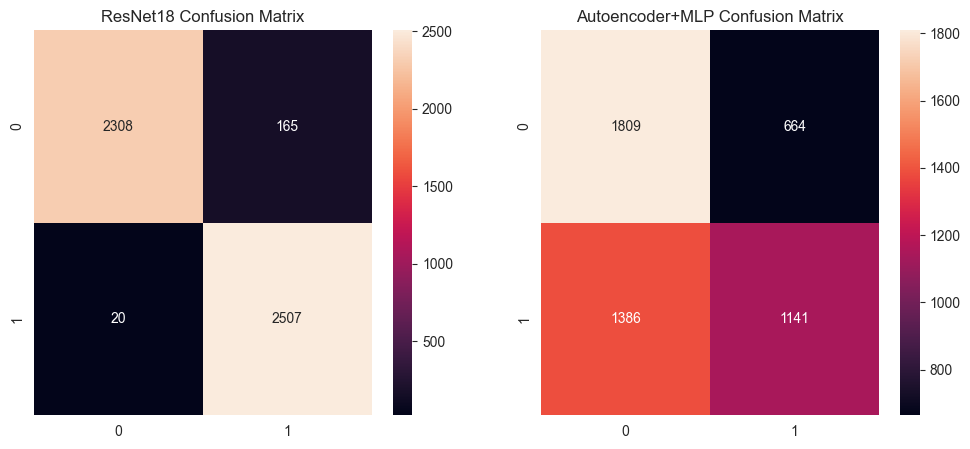

ResNet18 Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.93      0.96      2473
           1       0.94      0.99      0.96      2527

    accuracy                           0.96      5000
   macro avg       0.96      0.96      0.96      5000
weighted avg       0.96      0.96      0.96      5000

Autoencoder + MLP Classification Report:
              precision    recall  f1-score   support

           0       0.57      0.73      0.64      2473
           1       0.63      0.45      0.53      2527

    accuracy                           0.59      5000
   macro avg       0.60      0.59      0.58      5000
weighted avg       0.60      0.59      0.58      5000



In [19]:
import torch
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np  # Make sure numpy is imported

# Assuming your CatsDogsDataModule is already defined as before
data_module = CatsDogsDataModule(data_dir="data", batch_size=32, image_size=128)

# Set up the datasets and dataloaders (train, val, and test)
data_module.setup(stage="fit")  # This splits the dataset into train/val

# Use the validation data for evaluation
val_loader = data_module.val_dataloader()

# Check if GPU (cuda) or Apple MPS is available, and use the appropriate device
device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")

# Assuming your models are loaded and ready (ResNet and Autoencoder+MLP)
# Ensure models are on the correct device
resnet_model = resnet_model.to(device)
autoencoder = autoencoder.to(device)
mlp_model = mlp_model.to(device)

# Initialize lists to store predictions and true labels
resnet_preds, resnet_targets = [], []
mlp_preds, mlp_targets = [], []

# Iterate over validation data to get predictions from both models
for x, y in val_loader:
    # Move tensors to the correct device (e.g., GPU or MPS)
    x = x.to(device)  # Ensure x is moved to the correct device
    y = y.to(device)  # Same for labels

    # ResNet predictions
    resnet_outputs = resnet_model(x)  # Ensure ResNet is on the correct device
    resnet_preds.extend(resnet_outputs.argmax(dim=1).cpu().numpy())  # Convert predictions to numpy
    resnet_targets.extend(y.cpu().numpy())  # Convert true labels to numpy before appending
    
    # Autoencoder + MLP predictions
    # Assuming you're extracting embeddings from the autoencoder before passing to MLP
    #z = autoencoder.encoder(x)  # Get the embeddings from the encoder
    with torch.no_grad():
        z = autoencoder.encoder(x)  # x should be [B, 3, 128, 128]
        z = torch.nn.functional.adaptive_avg_pool2d(z, (1, 1))  # [B, C, 1, 1]
        z = z.view(z.size(0), -1)  # flatten to [B, C]
 

    mlp_outputs = mlp_model(z)  # Feed embeddings to the MLP
    
    mlp_preds.extend(mlp_outputs.argmax(dim=1).cpu().numpy())  # Convert predictions to numpy
    mlp_targets.extend(y.cpu().numpy())  # Convert true labels to numpy before appending

# Convert lists to numpy arrays for sklearn metrics
resnet_targets = np.array(resnet_targets, dtype=int).flatten()
resnet_preds = np.array(resnet_preds, dtype=int).flatten()
mlp_targets = np.array(mlp_targets, dtype=int).flatten()
mlp_preds = np.array(mlp_preds, dtype=int).flatten()

# Calculate accuracy
resnet_acc = accuracy_score(resnet_targets, resnet_preds)
mlp_acc = accuracy_score(mlp_targets, mlp_preds)

# Print accuracy
print(f"ResNet18 Accuracy on Validation Set: {resnet_acc:.4f}")
print(f"Autoencoder+MLP Accuracy on Validation Set: {mlp_acc:.4f}")

# Confusion Matrix for ResNet18
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# ResNet confusion matrix
sns.heatmap(confusion_matrix(resnet_targets, resnet_preds), annot=True, fmt='d', ax=axs[0])
axs[0].set_title("ResNet18 Confusion Matrix")

# Autoencoder+MLP confusion matrix
sns.heatmap(confusion_matrix(mlp_targets, mlp_preds), annot=True, fmt='d', ax=axs[1])
axs[1].set_title("Autoencoder+MLP Confusion Matrix")

plt.show()

# Classification Reports
print("ResNet18 Classification Report:")
print(classification_report(resnet_targets, resnet_preds))

print("Autoencoder + MLP Classification Report:")
print(classification_report(mlp_targets, mlp_preds))


## Evaluate Autoencoder + Classifier 
### Given the limitations observed with the Autoencoder + MLP approach, I next evaluated a joint Autoencoder + Classifier model. This end-to-end approach trained the autoencoder’s latent space directly for classification, allowing the feature representations to be optimized specifically for distinguishing cats and dogs. I wondered the extent to which integrating feature learning and classification into a single model could improve accuracy compared to the unsupervised autoencoder features followed by a separate classifier.

/Users/George/deep-learning-project-template/.venv/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Autoencoder Classifier Accuracy on Validation Set: 0.7546
Classification Report:
               precision    recall  f1-score   support

           0     0.7319    0.8168    0.7721      2544
           1     0.7844    0.6901    0.7342      2456

    accuracy                         0.7546      5000
   macro avg     0.7582    0.7535    0.7532      5000
weighted avg     0.7577    0.7546    0.7535      5000



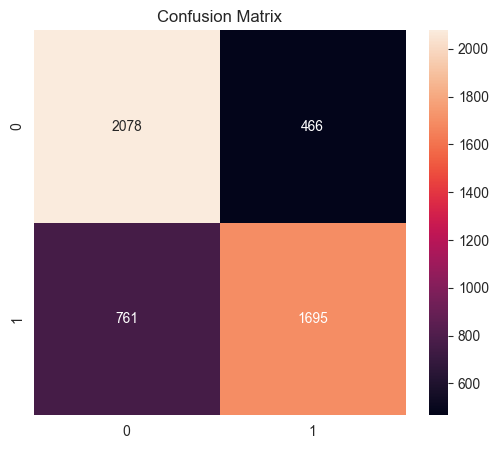

In [5]:
import torch
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import glob
from project.data_module import CatsDogsDataModule
from project.lit_autoencoder import LitAutoEncoder

def main():
    # Load best checkpoint
    checkpoint_path = "checkpoints/best_autoencoder_classifier-epoch=*.ckpt"

    # Use glob to find the checkpoint file(s)
    checkpoint_files = sorted(glob.glob(checkpoint_path))
    if not checkpoint_files:
        raise FileNotFoundError("Checkpoint not found.")
    checkpoint = checkpoint_files[-1]  # Get the most recent checkpoint

    # Load model from checkpoint
    model = LitAutoEncoder.load_from_checkpoint(checkpoint, classify=True)
    model.eval()  # Set model to evaluation mode
    model.freeze()  # Optionally freeze model layers if needed

    # Set up the datasets and dataloaders (train, val, and test)
    data_module = CatsDogsDataModule(data_dir="data", batch_size=32, image_size=128)
    data_module.setup(stage="fit")  # This splits the dataset into train/val
    val_loader = data_module.val_dataloader()  # Use validation data for evaluation

    # Check if GPU (cuda) or Apple MPS is available, and use the appropriate device
    device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")

    # Move the model to the correct device (GPU/MPS/CPU)
    model.to(device)

    # Initialize lists to store predictions and true labels
    all_preds, all_labels = [], []

    # Iterate over validation data to get predictions
    with torch.no_grad():
        for x, y in val_loader:
            # Move tensors to the correct device
            x = x.to(device)
            y = y.to(device)

            # Run the model and get predictions
            logits = model(x)
            preds = torch.argmax(logits, dim=1)
            all_preds.append(preds.cpu())
            all_labels.append(y.cpu())

    # Flatten the tensors and convert to numpy arrays for sklearn metrics
    all_preds = torch.cat(all_preds).numpy()
    all_labels = torch.cat(all_labels).numpy()

    # Calculate accuracy
    acc = accuracy_score(all_labels, all_preds)
    print(f"Autoencoder Classifier Accuracy on Validation Set: {acc:.4f}")

    # Print classification report
    report = classification_report(all_labels, all_preds, digits=4)
    print("Classification Report:\n", report)

    # Calculate and print confusion matrix
    fig, axs = plt.subplots(1, 1, figsize=(6, 5))
    sns.heatmap(confusion_matrix(all_labels, all_preds), annot=True, fmt='d', ax=axs)
    axs.set_title("Confusion Matrix")
    plt.show()

if __name__ == "__main__":
    main()


### The accuracy was indeed improved with this semi-supervised approach to using the autoencoder (0.7546 vs. 0.59), though still not as good at the ResNet18, which is to be expected. Similar to before, I wanted to visualize the data to better understand why it is performing better and how I could improve it further.

/Users/George/deep-learning-project-template/.venv/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


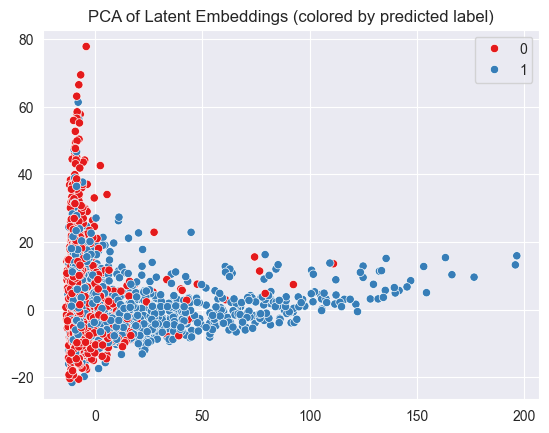

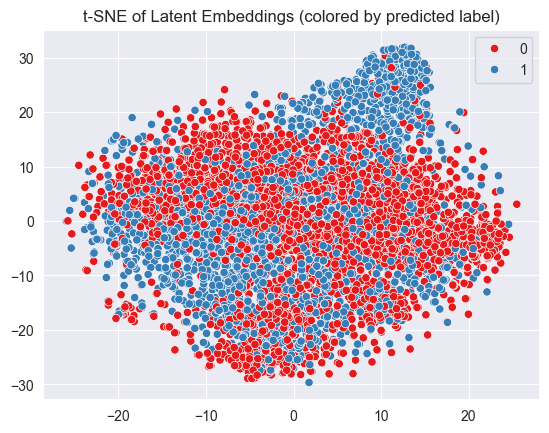

In [12]:
import torch
import glob
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from project.lit_autoencoder import LitAutoEncoder
from project.data_module import CatsDogsDataModule

# Load best checkpoint
checkpoint_list = sorted(glob.glob("checkpoints/best_autoencoder_classifier-epoch=*.ckpt"))
if not checkpoint_list:
    raise FileNotFoundError("No checkpoint file found in 'checkpoints/' directory.")
checkpoint_path = checkpoint_list[-1]

model = LitAutoEncoder.load_from_checkpoint(checkpoint_path, classify=True)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device).eval().freeze()

# Set up test/val loader
data_module = CatsDogsDataModule(data_dir="data", batch_size=32, image_size=128)
data_module.setup(stage="fit")
test_loader = data_module.val_dataloader()

# Embedding collection
X_embed, y_true, y_pred = [], [], []

with torch.no_grad():
    for x, y in test_loader:
        x = x.to(device)
        y = y.to(device)

        z = model.encoder(x)
        logits = model.classifier(z)
        preds = torch.argmax(logits, dim=1)

        X_embed.append(z.cpu())
        y_true.append(y.cpu())
        y_pred.append(preds.cpu())

X_embed = torch.cat(X_embed).numpy()
y_pred = torch.cat(y_pred).numpy()
y_true = torch.cat(y_true).numpy()

# PCA
X_flat = X_embed.reshape(X_embed.shape[0], -1)  # Flatten latent features
X_2d_pca = PCA(n_components=2).fit_transform(X_flat)
sns.scatterplot(x=X_2d_pca[:, 0], y=X_2d_pca[:, 1], hue=y_pred, palette="Set1")
plt.title("PCA of Latent Embeddings (colored by predicted label)")
plt.show()

# t-SNE
X_2d_tsne = TSNE(n_components=2, perplexity=30).fit_transform(X_flat)
sns.scatterplot(x=X_2d_tsne[:, 0], y=X_2d_tsne[:, 1], hue=y_pred, palette="Set1")
plt.title("t-SNE of Latent Embeddings (colored by predicted label)")
plt.show()


## Reconstruction Visualization with Difference Plots

Reconstruction value range: 0.4434022307395935 0.5764849781990051


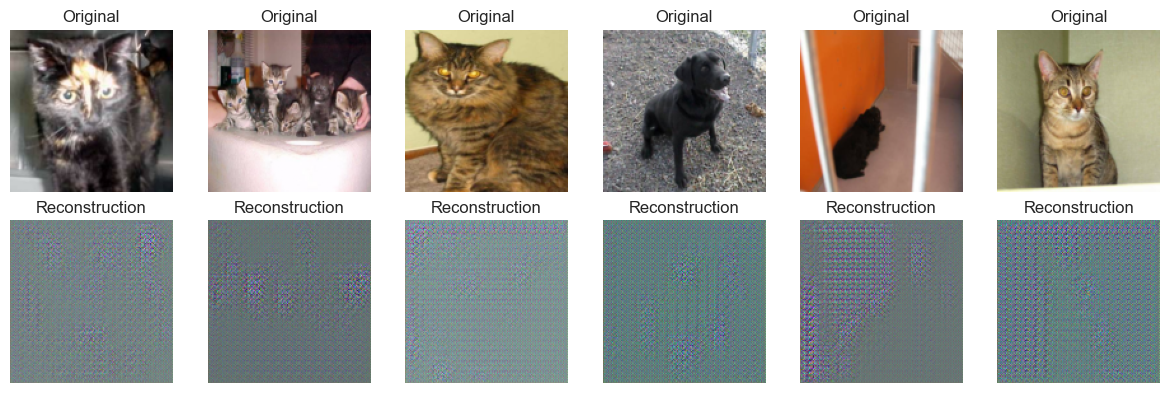

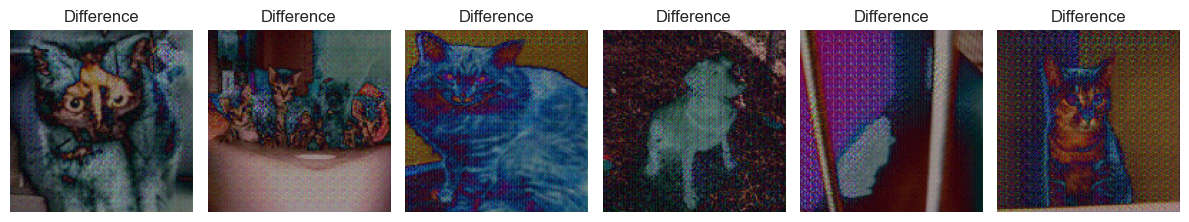

In [22]:
import torch
import matplotlib.pyplot as plt
import glob
from project.lit_autoencoder import LitAutoEncoder
from project.data_module import CatsDogsDataModule

def normalize_tensor(tensor):
    # Min-max normalize per image (all channels and pixels)
    tensor_min = tensor.view(tensor.size(0), -1).min(dim=1)[0].view(-1, 1, 1, 1)
    tensor_max = tensor.view(tensor.size(0), -1).max(dim=1)[0].view(-1, 1, 1, 1)
    normalized = (tensor - tensor_min) / (tensor_max - tensor_min + 1e-8)
    return normalized

def visualize_reconstruction(autoencoder, dataloader, device=None, n_images=6, show_difference=True):
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
    else:
        device = torch.device(device)

    autoencoder.to(device)
    autoencoder.eval()

    x_batch, _ = next(iter(dataloader))
    x_batch = x_batch.to(device)

    with torch.no_grad():
        z = autoencoder.encoder(x_batch)
        x_hat = autoencoder.decoder(z)
        print("Reconstruction value range:", x_hat.min().item(), x_hat.max().item())

    originals = x_batch.cpu()
    reconstructions = x_hat.cpu()

    # Normalize for visualization
    originals = normalize_tensor(originals)
    reconstructions = normalize_tensor(reconstructions)

    # Plot originals and reconstructions side-by-side
    fig, axes = plt.subplots(2, n_images, figsize=(12, 4))
    for i in range(n_images):
        axes[0, i].imshow(originals[i].permute(1, 2, 0))
        axes[0, i].axis('off')
        axes[0, i].set_title("Original")

        axes[1, i].imshow(reconstructions[i].permute(1, 2, 0))
        axes[1, i].axis('off')
        axes[1, i].set_title("Reconstruction")
    plt.tight_layout()
    plt.show()

    if show_difference:
        diff = torch.abs(originals - reconstructions)
        fig, axes = plt.subplots(1, n_images, figsize=(12, 3))
        for i in range(n_images):
            axes[i].imshow(diff[i].permute(1, 2, 0), cmap='inferno')
            axes[i].axis('off')
            axes[i].set_title("Difference")
        plt.tight_layout()
        plt.show()

if __name__ == "__main__":
    checkpoint_files = sorted(glob.glob("checkpoints/best_autoencoder_classifier-epoch=*.ckpt"))
    if not checkpoint_files:
        raise FileNotFoundError("No checkpoint found in 'checkpoints/'")
    checkpoint_path = checkpoint_files[-1]

    model = LitAutoEncoder.load_from_checkpoint(checkpoint_path, classify=True)

    data_module = CatsDogsDataModule(data_dir="data", batch_size=32, image_size=128)
    data_module.setup(stage="fit")
    val_loader = data_module.val_dataloader()

    visualize_reconstruction(model, val_loader)


### I studied many examples of these difference plots to understand what feature(s) the autoencoder with classifier is capturing that improves its performance over the autoencoder + MLP approach. For each pixel (and each color channel), the difference plot shows the absolute value of (original_pixel_value - reconstructed_pixel_value). These difference plots visualize the model’s reconstruction errors on a pixel-by-pixel basis, highlighting where the autoencoder’s output deviates from the input images. This helps interpret the quality and focus of the learned image representation. Typically, edges and contours stand out in these plots because they are key features the autoencoder learns to capture. In particular, edges carry the most discriminative information for reconstruction and downstream classification tasks.

## *Conclusion*

## This project demonstrated that integrating feature learning and classification in a joint autoencoder+classifier model leads to improved performance over a separate autoencoder+MLP pipeline. By examining difference plots, I confirmed that the model focuses on capturing meaningful image features such as edges and contours, which are crucial for distinguishing cats from dogs. Overall, this work highlights the value of end-to-end training for learning task-relevant representations in image classification.

### APPENDIX: Additional files can be found in my GitHub repository at https://github.com/gtg975n/cats-vs-dogs-classifier